# Analysis of the Porto Taxi Data from 01/07/2013 to 31/12/2013

Dataset source: https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i/data?select=train.csv.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## I. Statistical characteristics of the original dataset:

In [ ]:
import numpy as np
import pandas as pd

import datetime, gc, random
import json, numpy as np, pandas as pd, zipfile
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.cluster import MeanShift, estimate_bandwidth
import warnings; warnings.simplefilter('ignore')

# file
import zipfile

# Data preprocessing
import datetime as dt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Visualization
from matplotlib import pyplot as plt
%matplotlib inline
import folium
import seaborn as sns
sns.set()
sns.set_theme(style="ticks", color_codes=True)
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


In [ ]:
path = "/content/drive/MyDrive/Bachelorarbeit/BA_PortoTaxiDataset.csv"

df = pd.read_csv(path)
df['pickup_datetime']=pd.to_datetime(df['TIMESTAMP'], unit='s')
df = df[df['pickup_datetime'].dt.strftime('%Y') == '2013']
#df = df.sample(n=858267, random_state = 2).reset_index(drop=True)
df = df.drop(['pickup_datetime'], axis = 1).reset_index(drop=True)
df.reset_index()

print('This dataset has',df.shape[0],'rows and',df.shape[1],'columns.')
print('Statistical data of the original Dataset:')
df.describe()

This dataset has 858691 rows and 9 columns.
Statistical data of the original Dataset:


,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP
count,8.586910e+05,181903.000000,415435.000000,8.586910e+05,8.586910e+05
mean,1.380675e+18,23914.403446,30.295887,2.000035e+07,1.380675e+09
std,4.574538e+15,19602.373745,17.807680,2.099432e+02,4.574538e+06
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09
25%,1.376735e+18,5914.000000,15.000000,2.000017e+07,1.376735e+09
50%,1.380762e+18,17872.000000,27.000000,2.000034e+07,1.380762e+09
75%,1.384572e+18,40092.500000,49.000000,2.000052e+07,1.384572e+09
max,1.388534e+18,63884.000000,63.000000,2.000098e+07,1.388534e+09


# II: Datastructure
###The raw data originally consists of 858267  rows and 9 columns.
The records can be categorized as following:

1. Administrative data: *TRIP_ID, CALL_TYPE, ORIGIN_CALL, ORIGIN_STAND, TAXI_ID* 
2. Trip data: *TIMESTAMP, DAYTYPE, MISSING_DATA, POLYLINE* 


In [ ]:
print('Columns of the original Dataset:')
df.columns

Columns of the original Dataset:


Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE'],
      dtype='object')

# III. Dataset Exploration
For the coming steps, we will address:
1. Data types of the columns
2. Missing data by checking for null variables
3. Sum of unique values in each column

## 1. Data types
We noticed that the call type and day type  are of type object. We will need to convert that later in feature engineering section.

In [ ]:
print('Original dataframe information:')
df.info()

Original dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858691 entries, 0 to 858690
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   TRIP_ID       858691 non-null  int64  
 1   CALL_TYPE     858691 non-null  object 
 2   ORIGIN_CALL   181903 non-null  float64
 3   ORIGIN_STAND  415435 non-null  float64
 4   TAXI_ID       858691 non-null  int64  
 5   TIMESTAMP     858691 non-null  int64  
 6   DAY_TYPE      858691 non-null  object 
 7   MISSING_DATA  858691 non-null  bool   
 8   POLYLINE      858691 non-null  object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 53.2+ MB


## 2. Missing Variables
- Only Origin call and Origin stand have NULL variables which corresponds to the information provided from the dataset.

In [ ]:
#rows with 0 variables
df.isnull().sum()

TRIP_ID              0
CALL_TYPE            0
ORIGIN_CALL     676788
ORIGIN_STAND    443256
TAXI_ID              0
TIMESTAMP            0
DAY_TYPE             0
MISSING_DATA         0
POLYLINE             0
dtype: int64

## 3. Sum of unique values
After comparing the sum of the obtained unique values with the data dictionary for Porto taxi, rides the following results correspond to the informarion in the data dictionary:
- Taxi ID - there are only 442 taxi operating through the city
- Call Type - the service is demanded through only 3 possible ways
- Day Type - are only 3 variants
- Missing Data - has only 2 possible values

These values and their relevance are explained in more details in the next sections. 

In [ ]:
#sum unique variables within the rows
df.nunique()

TRIP_ID         858660
CALL_TYPE            3
ORIGIN_CALL      36712
ORIGIN_STAND        63
TAXI_ID            444
TIMESTAMP       831419
DAY_TYPE             1
MISSING_DATA         2
POLYLINE        855522
dtype: int64

# IV. Feature Engineering


In this section we will do the following:
- Copy the dataset and change all the column names to lowercase to start preprocessing conveniently
- Preprocess the Polyline
- Add few extra columns to help us further with the analysis
- Remove obvious outliers

In [ ]:
# change all variable names to lower case letters
df.columns = [i.strip().lower() for i in list(df.columns)]
df.columns

Index(['trip_id', 'call_type', 'origin_call', 'origin_stand', 'taxi_id',
       'timestamp', 'day_type', 'missing_data', 'polyline'],
      dtype='object')

##1. Extracting coordinates from Polyline
source: https://www.kaggle.com/dahouda/taxi-trajectory-prediction-i/notebook

Extracting the coordinates in form of latitude and longitude of the starting point of the trip and the destination.

In [ ]:
# First longitude in polyline
pickup_longitude_list = []
for i in range(0,len(df["polyline"])):
    if df["polyline"][i] == '[]':
        k=0
        pickup_longitude_list.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", df["polyline"][i]).split(",")[0]
        pickup_longitude_list.append(k)
        
df["pickup_longitude"] = pickup_longitude_list

# First latitude in polyline
pickup_latitude_list = []
for i in range(0,len(df["polyline"])):
    if df["polyline"][i] == '[]':
        k=0
        pickup_latitude_list.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", df["polyline"][i]).split(",")[1]
        pickup_latitude_list.append(k)
        
df["pickup_latitude"] = pickup_latitude_list

In [ ]:
# Last longitude in polyline
dropoff_longitude_list = []
for i in range(0,len(df["polyline"])):
        if df["polyline"][i] == '[]':
            k=0
            dropoff_longitude_list.append(k)
        else:
            k = re.sub(r"[[|[|]|]|]]", "", df["polyline"][i]).split(",")[-2]
            dropoff_longitude_list.append(k)

df["dropoff_longitude"] = dropoff_longitude_list

# Last latitude in polyline
dropoff_latitude_list = []
for i in range(0,len(df["polyline"])):
    if df["polyline"][i] == '[]':
        k=0
        dropoff_latitude_list.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", df["polyline"][i]).split(",")[-1]
        dropoff_latitude_list.append(k)
        
df["dropoff_latitude"] = dropoff_latitude_list

In [ ]:
# changing type string to float
df["pickup_longitude"] = [float(k) for k in df["pickup_longitude"]]
df["pickup_latitude"] = [float(k) for k in df["pickup_latitude"]]
df["dropoff_longitude"] = [float(k) for k in df["dropoff_longitude"]]
df["dropoff_latitude"] = [float(k) for k in df["dropoff_latitude"]]

##2. Extracting trip distance and speed from Polyline



**Trip Distance:**
the sum of distances between each two consecutive pairs of coordinates within the polyline in kilometers.

**Trip Duration:**
trip coordinates are updated and recorded every 15 seconds. Therefore, the trip duration in minutes will be: (total number of coordinate pairs in polyline -1) x 15 seconds / 60 seconds.

**Average Speed:** The average speed is the trip distance divided by the trip time in hours. The result is in km/h.


In [ ]:
import multiprocessing as mp
import geopy.distance
import csv
from datetime import datetime, timezone
from tqdm import tqdm
tqdm.pandas()

In [ ]:
def process_polyline(p):
    p = eval(p)
    if len(p) > 1:
        trip_distance = 0
        for i in range(len(p) - 1):
            distance = geopy.distance.distance(p[i], p[i + 1]).km
            trip_distance += distance
        trip_time = (len(p) - 1) * 15 / 60
        avg_speed = trip_distance / trip_time * 60
        return trip_distance, trip_time, avg_speed
    else:
        return np.NaN, np.NaN, np.NaN

In [ ]:
def map_polyline(df_in):
    df_out = pd.DataFrame()
    df_out["trip_distance"], df_out["trip_time"], df_out[
        "avg_speed"
    ] = zip(
        *df_in["polyline"].progress_map(process_polyline)
    )
    return df_out
    

In [ ]:
p = mp.Pool(processes=mp.cpu_count())
pool_results = p.map(map_polyline, np.array_split(df, mp.cpu_count()))
p.close()
p.join()

# merging parts processed by different processes
new_columns = pd.concat(pool_results, axis=0, ignore_index=True)

# merging newly calculated columns to taxi
df = pd.concat([df, new_columns], axis=1)

##3. Preprocessing datetime
- Convert timestamp into readable datetime object.
- From the datetime object extract the pickup date, time, day number, weekday, month, hour and minute.
- With the trip duration obtained from the previous step and pickup datetime, calculate the dropoff time and then dropoff date, month, day number, weekday, hour and minute.
- Add an id column in the last step.

In [ ]:
#convert it to datetime
df['pickup_datetime']=pd.to_datetime(df['timestamp'], unit='s')
#extract the times
df['pickup_date']=pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d')
df['pickup_time']=pd.to_datetime(df['pickup_datetime'], format='%H:%M:%S')
df['pickup_date'] = df['pickup_datetime'].dt.date # Extract date
df['pickup_time'] = df['pickup_datetime'].dt.time # Extract time

df['pickup_weekday']=df['pickup_datetime'].dt.day_name()
df['pickup_day_no']=df['pickup_datetime'].dt.day
df['pickup_month']=df['pickup_datetime'].dt.month
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['pickup_minute']=df['pickup_datetime'].dt.minute

df['trip_time_delta'] = pd.to_timedelta(df['trip_time'], unit='m')

df['dropoff_datetime'] = df['pickup_datetime'] + df['trip_time_delta']

#convert it to datetime
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
#extract the times
df['dropoff_time']=pd.to_datetime(df['dropoff_datetime'], format='%H:%M:%S')
df['dropoff_date']=pd.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d')
df['dropoff_date'] = df['dropoff_datetime'].dt.date # Extract date
df['dropoff_time'] = df['dropoff_datetime'].dt.time # Extract time

df.dropna(subset=['dropoff_datetime', 'dropoff_date', 'dropoff_time'], inplace=True)

df['dropoff_weekday']=df['dropoff_datetime'].dt.day_name()
df['dropoff_day_no']=df['dropoff_datetime'].dt.day
df['dropoff_day_no']=df['dropoff_day_no'].apply(np.int64)
df['dropoff_month']=df['dropoff_datetime'].dt.month
df['dropoff_month']=df['dropoff_month'].apply(np.int64)
df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_hour'].apply(np.int64)
df['dropoff_minute']=df['dropoff_datetime'].dt.minute
df['dropoff_minute']=df['dropoff_minute'].apply(np.int64)

In [ ]:
#df.to_csv("/content/drive/MyDrive/Bachelorarbeit/2013_porto_taxi.csv.zip", index=None, compression="zip")

In [ ]:
df["id"] = df.index
df = df.reindex()

In [ ]:
#df.to_csv('/content/drive/MyDrive/Bachelorarbeit/2013_porto_taxi.csv')

In [ ]:
print('The modified dataset now has',df.shape[0],'rows and',df.shape[1],'columns.')

#V. Data Analysis and Filtering


In [ ]:
path = "/content/drive/MyDrive/Bachelorarbeit/2013_porto_taxi.csv"
df = pd.read_csv(path)

In [ ]:
#copy the original dataset before modification
df_orig = df.copy()

In [ ]:
df["id"] = df.index

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841892 entries, 0 to 841891
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         841892 non-null  int64  
 1   trip_id            841892 non-null  int64  
 2   call_type          841892 non-null  object 
 3   origin_call        180886 non-null  float64
 4   origin_stand       411225 non-null  float64
 5   taxi_id            841892 non-null  int64  
 6   timestamp          841892 non-null  int64  
 7   day_type           841892 non-null  object 
 8   missing_data       841892 non-null  bool   
 9   polyline           841892 non-null  object 
 10  pickup_longitude   841892 non-null  float64
 11  pickup_latitude    841892 non-null  float64
 12  dropoff_longitude  841892 non-null  float64
 13  dropoff_latitude   841892 non-null  float64
 14  trip_distance      841892 non-null  float64
 15  trip_time          841892 non-null  float64
 16  av

##1. Call Type


In [ ]:
start_n = len(df)
mask = df['call_type'].isin(['A' , 'B' , 'C'])
#display the mask
x = (mask == True)
print(len(x))

841892


In [ ]:
df['call_type'] = df.loc[mask, ['call_type']]
print('This step excludes',start_n - len(df),'records, current sample size=',len(df))

This step excludes 0 records, current sample size= 841892


##2. Origin Call

In [ ]:
start_n = len(df)
mask = df['call_type'].isin(['A' , NaN])
#display the mask
#mask.head()
x = (mask == True)
print(len(x))

##3. Origin Stand
if call type = B, origin stand has a value != Nan
if call type = A or C, origin stand value == Nan

In [ ]:
from numpy.core.numeric import NaN

y = df[(df['call_type'].str.contains('B')) & (df['origin_stand'] != NaN)]
#print('y', len(y))
z = len(y)

q = df[(df['call_type'].isin(['A' ,'C'])) & (df['origin_stand'] != NaN)]
#print('q', len(q))
w = len(q)

print('total:' , z + w, 'rows, df:', len(df), 'rows')

total: 841892 rows, df: 841892 rows


##4. Missing Data

In [ ]:
start_n = len(df)
df['missing_data'] = df['missing_data'] == False
print('This step excludes',start_n - len(df),'records, current sample size=',len(df))

This step excludes 0 records, current sample size= 841892


##5. Latitude and Longitude
- The coordinate ranges of Porto are approximately: 
  - Latitude is between 41.0 and 41.3 ,41.9
  - Longitude is between -8.3 and -8.7

In [ ]:
start_n = len(df)
# Remove coordinate outliers
df = df[df['pickup_longitude'] <= -8.3]
df = df[df['pickup_longitude'] >= -8.7]
df = df[df['pickup_latitude'] <= 41.3]
df = df[df['pickup_latitude'] >= 41.0]
df = df[df['dropoff_longitude'] <= -8.3]
df = df[df['dropoff_longitude'] >= -8.7]
df = df[df['dropoff_latitude'] <= 41.3]
df = df[df['dropoff_latitude'] >= 41.0]

print('This step excludes',start_n - len(df),'records, current sample size=',len(df))

This step excludes 6350 records, current sample size= 835542


## 6. Trip Duration
There are relatively few trip durations as low as 0 minutes and as high as 958 minutes.

Trips of 0 minutes duration could be cancelled by the passenger therefore we will remove them. 

Furthermore, we will remove trips with duration more than 80 minutes and less than 3 minutes. 


In [ ]:
df.trip_time.describe()

count    835542.000000
mean         11.967835
std          10.821194
min           0.250000
25%           7.000000
50%          10.000000
75%          14.500000
max         958.750000
Name: trip_time, dtype: float64

In [ ]:
df.trip_time.quantile(0.99)

44.5

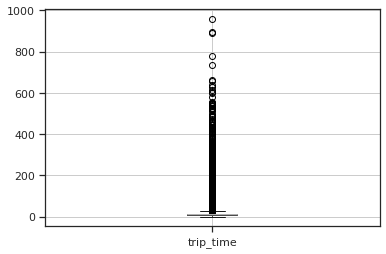

In [ ]:
df.boxplot(column=['trip_time'])

In [ ]:
(df['trip_time'] > 80).sum()

2182

In [ ]:
start_n = len(df)
df = df[(df['trip_time'] <= 80) & (df['trip_time'] >= 3)]
print('This step excludes',start_n - len(df),'records, current sample size=',len(df))

This step excludes 27724 records, current sample size= 807818


In [ ]:
df.trip_time.describe()

count    807818.000000
mean         11.954915
std           7.448730
min           3.000000
25%           7.250000
50%          10.250000
75%          14.500000
max          80.000000
Name: trip_time, dtype: float64

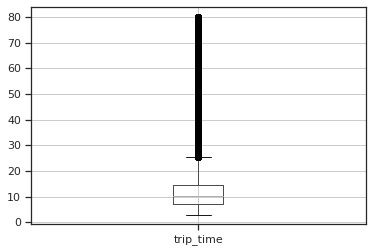

In [ ]:
df.boxplot(column=['trip_time'])

In [ ]:
df.trip_time.quantile(0.999)

69.5

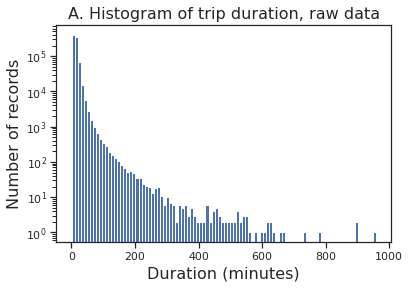

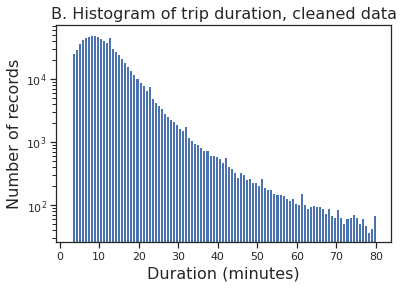

The average trip duration is 12.0 , the standard deviation is 7.4
The median trip duration is 10.2 , the 95% of trips distance fell between 3.75 to 30.8


In [ ]:
old = plt.hist(df_orig['trip_time'], bins=100);
plt.title('A. Histogram of trip duration, raw data', fontsize = 16)
plt.xlabel('Duration (minutes)', fontsize = 16)
plt.ylabel('Number of records', fontsize = 16)
plt.yscale('log')
plt.show(old)

new = plt.hist(df['trip_time'], bins=100);
plt.title('B. Histogram of trip duration, cleaned data', fontsize = 16)
plt.xlabel('Duration (minutes)', fontsize = 16)
plt.ylabel('Number of records', fontsize = 16);
plt.yscale('log')
plt.show(new)
'''
# plot distance with and without data cleaning
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 7)
fig.subplots_adjust(wspace=.5)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(df_orig['trip_time'],bins=100);
axs[0].set_title('A. Histogram of duration, raw data')
axs[0].set_xlabel('Duration (minutes)')
axs[0].set_ylabel('Number of records')

axs[1].hist(df['trip_time'],bins=100);
axs[1].set_title('B. Histogram of duration, cleaned data')
axs[1].set_xlabel('Duration (minutes)')
axs[1].set_ylabel('Number of records');

#fig.savefig('fig2.svg', format='svg',dpi=400, bbox_inches='tight')
'''
print('The average trip duration is',round(df['trip_time'].mean(),1),', the standard deviation is',round(df['trip_time'].std(),1))
print('The median trip duration is',round(df['trip_time'].median(),1),', the 95% of trips distance fell between',
      round(df['trip_time'].quantile(.025),2),'to',round(df['trip_time'].quantile(.975), 1))

In [ ]:
print('The modified dataset has',df.shape[0],'rows and',df.shape[1],'columns.')

The modified dataset has 807818 rows and 35 columns.


##7. Trip Distance
We removed trips with distances less than 1 kilometers and more than 30 kilometers after getting the 99.9th quantil 

In [ ]:
df.trip_distance.describe()

count    807818.000000
mean          6.340683
std           5.640555
min           0.005205
25%           2.987681
50%           4.790636
75%           7.793816
max        1330.584158
Name: trip_distance, dtype: float64

Text(0, 0.5, 'No. of Trips')

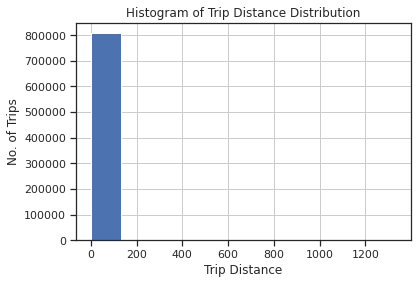

In [ ]:
df.hist(column='trip_distance')
plt.title("Histogram of Trip Distance Distribution")
plt.xlabel("Trip Distance")
plt.ylabel("No. of Trips")

In [ ]:
df.trip_distance.quantile(0.999)

43.0232070858589

In [ ]:
test = df.sort_values(by='trip_distance',ascending=True)
test.head(30)

,Unnamed: 0,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,trip_time,avg_speed,pickup_datetime,pickup_date,pickup_time,pickup_weekday,pickup_day_no,pickup_month,pickup_hour,pickup_minute,trip_time_delta,dropoff_datetime,dropoff_time,dropoff_date,dropoff_weekday,dropoff_day_no,dropoff_month,dropoff_hour,dropoff_minute,id
229619,234177,1376152036620000036,C,NaN,NaN,20000036,1376152036,A,True,"[[-8.660007,41.159934],[-8.660007,41.159934],[...",-8.660007,41.159934,-8.659989,41.159934,0.005205,3.25,0.096091,2013-08-10 16:27:16.000,2013-08-10,16:27:16,Saturday,10,8,16,27,0 days 00:00:03.250000,2013-08-10 16:27:19.250,16:27:19.250000,2013-08-10,Saturday,10,8,16,27,229619
591161,602735,1388154406620000060,A,33044.0,NaN,20000060,1388154406,A,True,"[[-8.645625,41.181561],[-8.645616,41.181561],[...",-8.645625,41.181561,-8.645634,41.181534,0.005958,3.75,0.095326,2013-12-27 14:26:46.000,2013-12-27,14:26:46,Friday,27,12,14,26,0 days 00:00:03.750000,2013-12-27 14:26:49.750,14:26:49.750000,2013-12-27,Friday,27,12,14,26,591161
619693,631848,1381836451620000649,C,NaN,NaN,20000649,1381836451,A,True,"[[-8.590563,41.18337],[-8.590563,41.18337],[-8...",-8.590563,41.183370,-8.590563,41.183361,0.009762,3.50,0.167357,2013-10-15 11:27:31.000,2013-10-15,11:27:31,Tuesday,15,10,11,27,0 days 00:00:03.500000,2013-10-15 11:27:34.500,11:27:34.500000,2013-10-15,Tuesday,15,10,11,27,619693
152376,155420,1384878664620000108,C,NaN,NaN,20000108,1384878664,A,True,"[[-8.632836,41.088978],[-8.632827,41.088978],[...",-8.632836,41.088978,-8.632854,41.088978,0.010577,3.50,0.181312,2013-11-19 16:31:04.000,2013-11-19,16:31:04,Tuesday,19,11,16,31,0 days 00:00:03.500000,2013-11-19 16:31:07.500,16:31:07.500000,2013-11-19,Tuesday,19,11,16,31,152376
681224,694465,1385544039620000685,C,NaN,NaN,20000685,1385544039,A,True,"[[-8.663598,41.16483],[-8.663598,41.164839],[-...",-8.663598,41.164830,-8.663598,41.164857,0.010579,3.00,0.211588,2013-11-27 09:20:39.000,2013-11-27,09:20:39,Wednesday,27,11,9,20,0 days 00:00:03,2013-11-27 09:20:42.000,09:20:42,2013-11-27,Wednesday,27,11,9,20,681224
682778,696053,1373600836620000496,C,NaN,NaN,20000496,1373600836,A,True,"[[-8.584668,41.164074],[-8.584668,41.164065],[...",-8.584668,41.164074,-8.584659,41.164056,0.011573,4.50,0.154301,2013-07-12 03:47:16.000,2013-07-12,03:47:16,Friday,12,7,3,47,0 days 00:00:04.500000,2013-07-12 03:47:20.500,03:47:20.500000,2013-07-12,Friday,12,7,3,47,682778
92561,94407,1373621274620000473,C,NaN,NaN,20000473,1373621274,A,True,"[[-8.591067,41.10561],[-8.591067,41.105619],[-...",-8.591067,41.105610,-8.591076,41.105601,0.011921,5.00,0.143055,2013-07-12 09:27:54.000,2013-07-12,09:27:54,Friday,12,7,9,27,0 days 00:00:05,2013-07-12 09:27:59.000,09:27:59,2013-07-12,Friday,12,7,9,27,92561
453245,462215,1377276804620000036,C,NaN,NaN,20000036,1377276804,A,True,"[[-8.659989,41.159916],[-8.659989,41.159916],[...",-8.659989,41.159916,-8.659989,41.159898,0.012221,3.25,0.225625,2013-08-23 16:53:24.000,2013-08-23,16:53:24,Friday,23,8,16,53,0 days 00:00:03.250000,2013-08-23 16:53:27.250,16:53:27.250000,2013-08-23,Friday,23,8,16,53,453245
514169,524288,1387291111620000039,C,NaN,NaN,20000039,1387291111,A,True,"[[-8.586,41.148927],[-8.586,41.148918],[-8.586...",-8.586000,41.148927,-8.586000,41.148918,0.012316,6.00,0.123163,2013-12-17 14:38:31.000,2013-12-17,14:38:31,Tuesday,17,12,14,38,0 days 00:00:06,2013-12-17 14:38:37.000,14:38:37,2013-12-17,Tuesday,17,12,14,38,514169
746528,761053,1382366086620000057,C,NaN,NaN,20000057,1382366086,A,True,"[[-8.545167,41.168124],[-8.545167,41.168124],[...",-8.545167,41.168124,-8.545194,41.168070,0.012558,4.50,0.167443,2013-10-21 14:34:46.000,2013-10-21,14:34:46,Monday,21,10,14,34,0 days 00:00:04.500000,2013-10-21 14:34:50.500,14:34:50.500000,2013-10-21,Monday,21,10,14,34,746528


In [ ]:
(df['trip_distance']>=30).sum()

3414

In [ ]:
start_n = len(df)
df = df[(df['trip_distance'] <= 30) & (df['trip_distance'] >= 1)]
print('This step excludes',start_n - len(df),'records, current sample size=',len(df))

This step excludes 11887 records, current sample size= 795931


In [ ]:
test = df.sort_values(by='trip_distance',ascending=False)
test.head(50)

,Unnamed: 0,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,trip_time,avg_speed,pickup_datetime,pickup_date,pickup_time,pickup_weekday,pickup_day_no,pickup_month,pickup_hour,pickup_minute,trip_time_delta,dropoff_datetime,dropoff_time,dropoff_date,dropoff_weekday,dropoff_day_no,dropoff_month,dropoff_hour,dropoff_minute,id
703913,717621,1387603305620000011,C,NaN,NaN,20000011,1387603305,A,True,"[[-8.591778,41.162931],[-8.591049,41.162607],[...",-8.591778,41.162931,-8.698212,41.203548,29.993765,26.75,67.275735,2013-12-21 05:21:45.000,2013-12-21,05:21:45,Saturday,21,12,5,21,0 days 00:00:26.750000,2013-12-21 05:22:11.750,05:22:11.750000,2013-12-21,Saturday,21,12,5,22,703913
224131,228583,1373559728620000093,B,NaN,33.0,20000093,1373559728,A,True,"[[-8.600175,41.182677],[-8.600022,41.182767],[...",-8.600175,41.182677,-8.541018,41.195115,29.992734,17.25,104.322553,2013-07-11 16:22:08.000,2013-07-11,16:22:08,Thursday,11,7,16,22,0 days 00:00:17.250000,2013-07-11 16:22:25.250,16:22:25.250000,2013-07-11,Thursday,11,7,16,22,224131
519899,530121,1373048846620000360,A,2001.0,NaN,20000360,1373048846,A,True,"[[-8.592462,41.146146],[-8.592471,41.146146],[...",-8.592462,41.146146,-8.631171,41.010975,29.992104,65.50,27.473683,2013-07-05 18:27:26.000,2013-07-05,18:27:26,Friday,5,7,18,27,0 days 00:01:05.500000,2013-07-05 18:28:31.500,18:28:31.500000,2013-07-05,Friday,5,7,18,28,519899
78556,80115,1385032729620000128,C,NaN,NaN,20000128,1385032729,A,True,"[[-8.648613,41.168511],[-8.64972,41.168826],[-...",-8.648613,41.168511,-8.689275,41.199840,29.992022,54.75,32.867970,2013-11-21 11:18:49.000,2013-11-21,11:18:49,Thursday,21,11,11,18,0 days 00:00:54.750000,2013-11-21 11:19:43.750,11:19:43.750000,2013-11-21,Thursday,21,11,11,19,78556
613095,625107,1373825326620000395,C,NaN,NaN,20000395,1373825326,A,True,"[[-8.654949,41.177637],[-8.658315,41.180418],[...",-8.654949,41.177637,-8.580618,41.100705,29.991377,37.75,47.668413,2013-07-14 18:08:46.000,2013-07-14,18:08:46,Sunday,14,7,18,8,0 days 00:00:37.750000,2013-07-14 18:09:23.750,18:09:23.750000,2013-07-14,Sunday,14,7,18,9,613095
85597,87301,1378500767620000688,C,NaN,NaN,20000688,1378500767,A,True,"[[-8.611479,41.161725],[-8.611461,41.161725],[...",-8.611479,41.161725,-8.630793,41.154498,29.985747,45.75,39.325569,2013-09-06 20:52:47.000,2013-09-06,20:52:47,Friday,6,9,20,52,0 days 00:00:45.750000,2013-09-06 20:53:32.750,20:53:32.750000,2013-09-06,Friday,6,9,20,53,85597
323013,329442,1373902574620000224,C,NaN,NaN,20000224,1373902574,A,True,"[[-8.619849,41.137605],[-8.61984,41.137605],[-...",-8.619849,41.137605,-8.592732,41.167746,29.984792,39.25,45.836625,2013-07-15 15:36:14.000,2013-07-15,15:36:14,Monday,15,7,15,36,0 days 00:00:39.250000,2013-07-15 15:36:53.250,15:36:53.250000,2013-07-15,Monday,15,7,15,36,323013
274521,280012,1377598794620000455,B,NaN,63.0,20000455,1377598794,A,True,"[[-8.609319,41.160105],[-8.609859,41.160357],[...",-8.609319,41.160105,-8.511318,41.118723,29.984562,54.00,33.316180,2013-08-27 10:19:54.000,2013-08-27,10:19:54,Tuesday,27,8,10,19,0 days 00:00:54,2013-08-27 10:20:48.000,10:20:48,2013-08-27,Tuesday,27,8,10,20,274521
458438,467512,1376058907620000386,C,NaN,NaN,20000386,1376058907,A,True,"[[-8.622099,41.173551],[-8.622342,41.177007],[...",-8.622099,41.173551,-8.678097,41.178456,29.983034,32.50,55.353293,2013-08-09 14:35:07.000,2013-08-09,14:35:07,Friday,9,8,14,35,0 days 00:00:32.500000,2013-08-09 14:35:39.500,14:35:39.500000,2013-08-09,Friday,9,8,14,35,458438
541691,552329,1378263992620000595,A,6654.0,NaN,20000595,1378263992,A,True,"[[-8.607213,41.145678],[-8.607123,41.145759],[...",-8.607213,41.145678,-8.639496,41.159790,29.982402,64.75,27.782921,2013-09-04 03:06:32.000,2013-09-04,03:06:32,Wednesday,4,9,3,6,0 days 00:01:04.750000,2013-09-04 03:07:36.750,03:07:36.750000,2013-09-04,Wednesday,4,9,3,7,541691


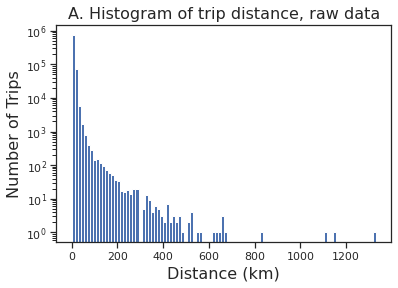

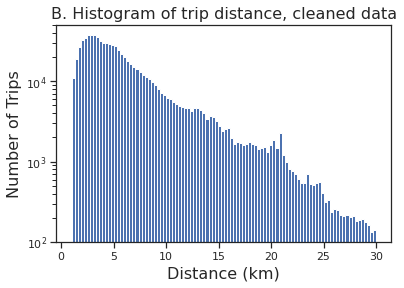

The average distance is 6.3 , the standard deviation is 4.7
The median distance is 4.8 , the 95% of trips distance fell between 1.44 to 19.9


In [ ]:
old = plt.hist(df_orig['trip_distance'], bins=100);
plt.title('A. Histogram of trip distance, raw data', fontsize = 16)
plt.xlabel('Distance (km)', fontsize = 16)
plt.ylabel('Number of Trips', fontsize = 16)
plt.yscale('log')
plt.show(old)

new = plt.hist(df['trip_distance'], bins=100);
plt.title('B. Histogram of trip distance, cleaned data', fontsize = 16)
plt.xlabel('Distance (km)', fontsize = 16)
plt.ylabel('Number of Trips', fontsize = 16);
plt.yscale('log')
plt.show(new)
'''
# plot distance with and without data cleaning
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 7)
fig.subplots_adjust(wspace=.5)

axs[0].hist(df_orig['trip_distance'],bins=100);
axs[0].set_title('A. Histogram of distance, raw data')
axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Number of Trips')

axs[1].hist(df['trip_distance'],bins=100);
axs[1].set_title('B. Histogram of distance, cleaned data')
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Number of Trips');

#fig.savefig('fig2.svg', format='svg',dpi=400, bbox_inches='tight')
'''
print('The average distance is',round(df['trip_distance'].mean(),1),', the standard deviation is',round(df['trip_distance'].std(),1))
print('The median distance is',round(df['trip_distance'].median(),1),', the 95% of trips distance fell between',
      round(df['trip_distance'].quantile(.025),2),'to',round(df['trip_distance'].quantile(.975), 1))

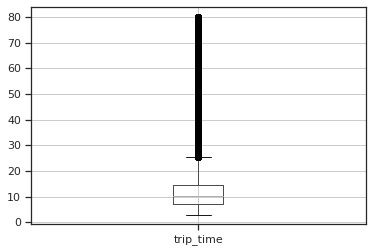

In [ ]:
df.boxplot(column=['trip_time'])

In [ ]:
print('The modified dataset has',df.shape[0],'rows and',df.shape[1],'columns.')

The modified dataset has 795931 rows and 35 columns.


##8. Average Trip Speed
We added a new column *trip_speed* which coresponds to the average speed of the trip. This will help with identifying trip outliers with extremely low or extremely high speeds.

According to https://www.autoeurope.com/travel-guides/portugal/driving-in-porto// the maximum speed limit within Porto is 50 km/h in urban areas, 80 km/h on secondary roads and 120 km/h on highways so we will start by eliminating rows with average trip speeds lower than 5 km/h and higher than 100 km/h. 

In the last step, we will remove trip speed observations that are more than four standard deviations away from the mean average speed.

In [ ]:
df.avg_speed.describe()

count    795931.000000
mean         31.950413
std          15.624348
min           0.944012
25%          21.336052
50%          28.300708
75%          38.542144
max         437.588609
Name: avg_speed, dtype: float64

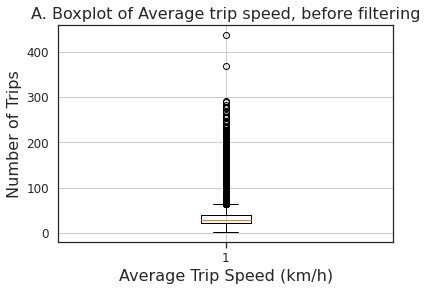

In [ ]:
plt.boxplot(df['avg_speed'])
plt.xlabel('Average Trip Speed (km/h)', fontsize=16)
plt.ylabel('Number of Trips', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('A. Boxplot of Average trip speed, before filtering', fontsize=16)
plt.savefig("boxtripspeednewnyc.png", transparent=True)
plt.grid(True)
plt.box(True)
plt.tick_params(left=False)
plt.show()


In [ ]:
start_n = len(df)
df = df[(df['avg_speed']<= 100) & (df['avg_speed'] > 5)]
print('This step excludes',start_n - len(df),'records, current sample size=',len(df))

This step excludes 2515 records, current sample size= 793416


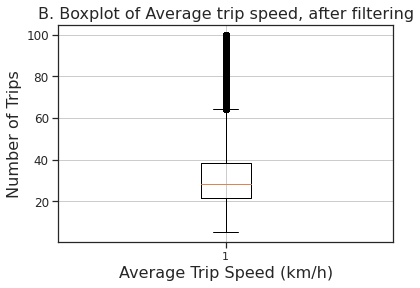

In [ ]:
plt.boxplot(df['avg_speed'])
plt.xlabel('Average Trip Speed (km/h)' , fontsize=16)
plt.ylabel('Number of Trips', fontsize=16)
plt.yticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('B. Boxplot of Average trip speed, after filtering', fontsize=16)
plt.savefig("boxtripspeednewporto.png", transparent=True)
plt.grid(True)
plt.box(True)
#plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
plt.show()

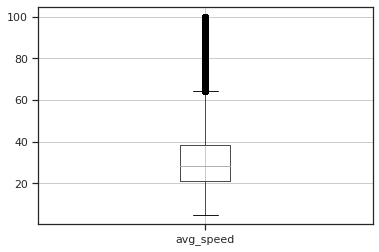

In [ ]:
df.boxplot(column=['avg_speed'])

In [ ]:
# Remove average speed outliers
start_n = len(df)
trip_speed_mean = np.mean(df['avg_speed'])
trip_speed_std = np.std(df['avg_speed'])
df = df[df['avg_speed']<=trip_speed_mean + 4*trip_speed_std]
df = df[df['avg_speed']>= trip_speed_mean - 4*trip_speed_std]
print('This step excludes',start_n - len(df),'records, current sample size=',len(df))

This step excludes 1495 records, current sample size= 791921


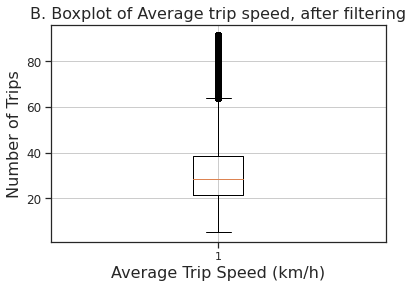

In [ ]:
plt.boxplot(df['avg_speed'])
plt.xlabel('Average Trip Speed (km/h)' , fontsize=16)
plt.ylabel('Number of Trips', fontsize=16)
plt.yticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('B. Boxplot of Average trip speed, after filtering', fontsize=16)
plt.savefig("boxtripspeednewnyc.png", transparent=True)
plt.grid(True)
plt.box(True)
#plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
plt.show()

Text(0, 0.5, 'No. of Trips')

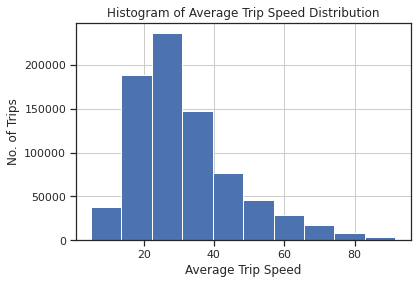

In [ ]:
df.hist(column='avg_speed')
plt.title("Histogram of Average Trip Speed Distribution")
plt.xlabel("Average Trip Speed")
plt.ylabel("No. of Trips")

In [ ]:
df['avg_speed'].describe()

count    791921.000000
mean         31.657286
std          14.716829
min           5.002024
25%          21.327473
50%          28.254426
75%          38.371013
max          91.594635
Name: avg_speed, dtype: float64

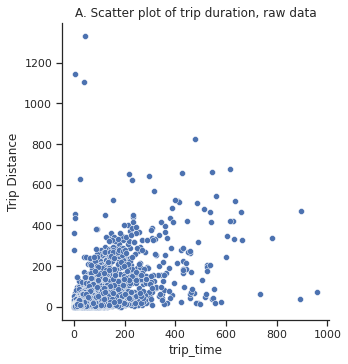

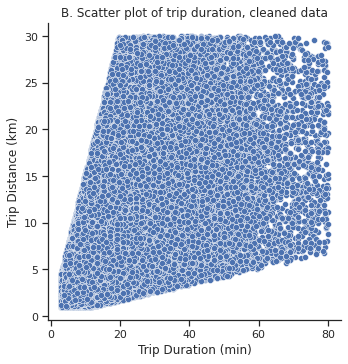

The average trip speed is 11.9 km/h, the standard deviation is 7.0 km/h
The median trip speed is 10.2 , the 95% of trip duration fell between 3.75 to 29.5 km/h


In [ ]:
import pylab as pl

old = sns.relplot(y=df_orig.trip_distance, x='trip_time',data=df_orig, kind="scatter")
pl.xlabel("trip_time")
pl.ylabel("Trip Distance")
pl.title("A. Scatter plot of trip duration, raw data")
pl.show(old)

new = sns.relplot(y=df.trip_distance,x='trip_time',data=df, kind="scatter" )
pl.xlabel("Trip Duration (min)")
pl.ylabel("Trip Distance (km)")
pl.title("B. Scatter plot of trip duration, cleaned data")
pl.show(new)
#fig.savefig('fig2.svg', format='svg',dpi=400, bbox_inches='tight')

print('The average trip speed is',round(df['trip_time'].mean(),1),'km/h, the standard deviation is',round(df['trip_time'].std(),1), 'km/h')
print('The median trip speed is',round(df['trip_time'].median(),1),', the 95% of trip duration fell between', round(df['trip_time'].quantile(.025),2),'to',round(df['trip_time'].quantile(.975), 1), 'km/h')

The average speed is 31.7 , the standard deviation is 14.7
The median speed is 28.3 , the 95% of average trips speed fell between 11.77 to 70.1


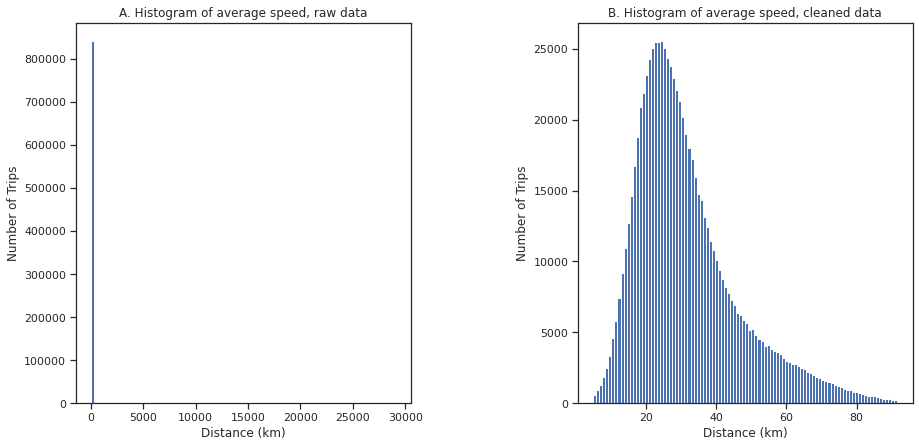

In [ ]:
# plot distance with and without data cleaning
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 7)
fig.subplots_adjust(wspace=.5)

axs[0].hist(df_orig['avg_speed'],bins=100);
axs[0].set_title('A. Histogram of average speed, raw data')
axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Number of Trips')

axs[1].hist(df['avg_speed'],bins=100);
axs[1].set_title('B. Histogram of average speed, cleaned data')
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Number of Trips');

#fig.savefig('fig2.svg', format='svg',dpi=400, bbox_inches='tight')

print('The average speed is',round(df['avg_speed'].mean(),1),', the standard deviation is',round(df['avg_speed'].std(),1))
print('The median speed is',round(df['avg_speed'].median(),1),', the 95% of average trips speed fell between',
      round(df['avg_speed'].quantile(.025),2),'to',round(df['avg_speed'].quantile(.975), 1))

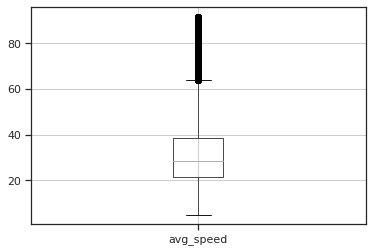

In [ ]:
df.boxplot(column=['avg_speed'])



---



---
#**Summary of Data Filtering Results:**

---


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,791921.0,4.292707e+05,2.478081e+05,0.000000e+00,2.146070e+05,4.293750e+05,6.439780e+05,8.582660e+05
trip_id,791921.0,1.380669e+18,4.558595e+15,1.372637e+18,1.376746e+18,1.380778e+18,1.384538e+18,1.388534e+18
origin_call,173564.0,2.390322e+04,1.959997e+04,2.001000e+03,5.906750e+03,1.782000e+04,4.008200e+04,6.388400e+04
origin_stand,394462.0,3.024280e+01,1.777535e+01,1.000000e+00,1.500000e+01,2.700000e+01,4.900000e+01,6.300000e+01
taxi_id,791921.0,2.000035e+07,2.097371e+02,2.000000e+07,2.000017e+07,2.000034e+07,2.000052e+07,2.000090e+07
timestamp,791921.0,1.380669e+09,4.558595e+06,1.372637e+09,1.376746e+09,1.380778e+09,1.384538e+09,1.388534e+09
pickup_longitude,791921.0,-8.616992e+00,2.442314e-02,-8.699967e+00,-8.628732e+00,-8.612667e+00,-8.603937e+00,-8.304012e+00
pickup_latitude,791921.0,4.115662e+01,1.249697e-02,4.100033e+01,4.114773e+01,4.115426e+01,4.116278e+01,4.129939e+01
dropoff_longitude,791921.0,-8.620350e+00,3.109019e-02,-8.699994e+00,-8.640675e+00,-8.615178e+00,-8.602830e+00,-8.309817e+00
dropoff_latitude,791921.0,4.116185e+01,2.416972e-02,4.100017e+01,4.114851e+01,4.115741e+01,4.116996e+01,4.129989e+01


# VI. Explanatory Analysis

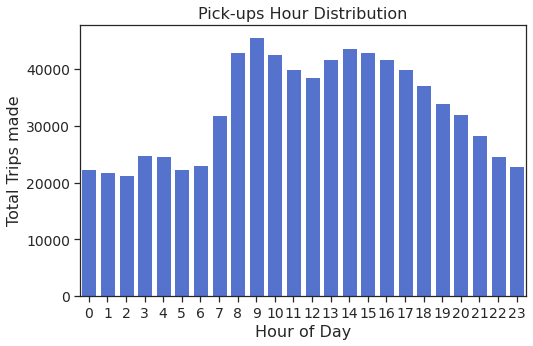

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,5))

bar_df = df.groupby('pickup_hour').aggregate({'id':'count'}).reset_index()
#sinplot()
sns.barplot(x='pickup_hour', y='id', data=bar_df, color = "royalblue")
plt.title('Pick-ups Hour Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Total Trips made', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("pickupshourDistPorto.png", transparent=True)
plt.show()


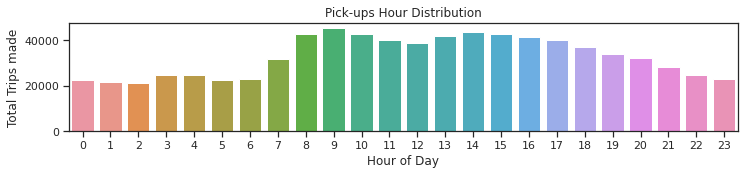

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,2))

bar_df = df.groupby('pickup_hour').aggregate({'id':'count'}).reset_index()
sns.barplot(x='pickup_hour', y='id', data=bar_df, color="b" )

plt.title('Pick-ups Hour Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trips made')
plt.savefig("pickupshourDistPorto.png", transparent=True)
plt.show()

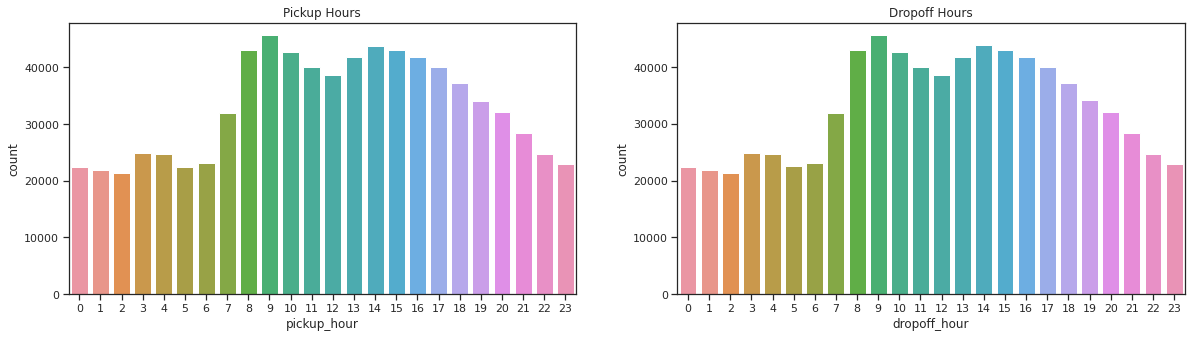

In [ ]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))
ax9.set_title('Pickup Hours')
ax=sns.countplot(x="pickup_hour",data=df,ax=ax9)
ax10.set_title('Dropoff Hours')
ax=sns.countplot(x="dropoff_hour",data=df,ax=ax10)

### Trips per Weekday

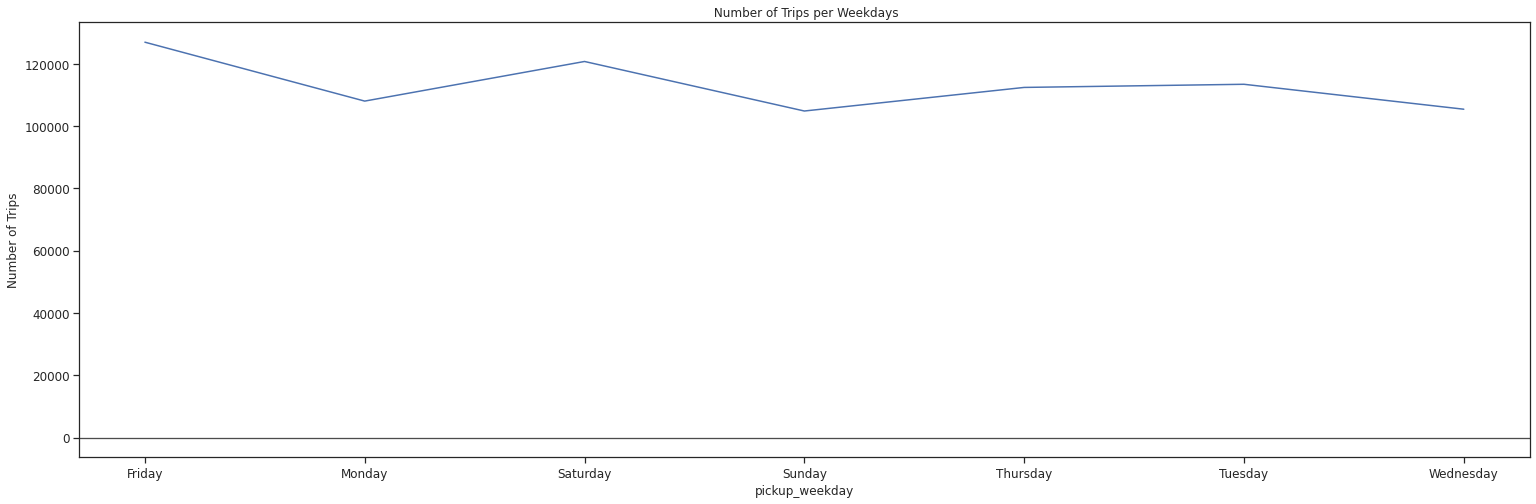

In [ ]:
# Summarize total trips by day
pickups_by_day = df.groupby('pickup_weekday').count()['id']

# Create graph
pickups_graph = pickups_by_day.plot(x = 'pickup_weekday',  figsize = (26,8))

# Customize tick size
pickups_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Bold horizontal line at y = 0
pickups_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

pickups_graph.set_title(' Number of Trips per Weekdays')
pickups_graph.xaxis.label.set_visible(True)
pickups_graph.set_ylabel('Number of Trips')
pickups_graph.yaxis.label.set_visible(True)

plt.show()

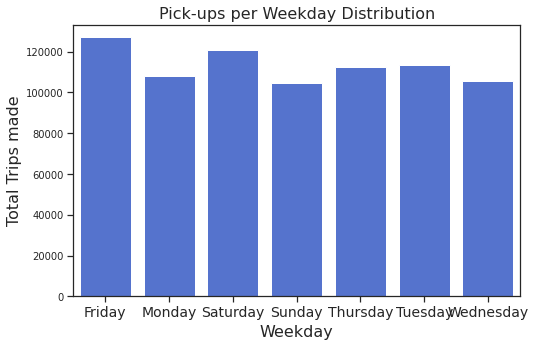

In [ ]:
#plt.set_title('Pickup Days')
plt.figure(figsize=(8,5))

bar_df = df.groupby('pickup_weekday').aggregate({'id':'count'}).reset_index()
sns.barplot(x='pickup_weekday', y='id', data=bar_df, color="royalblue")
#
plt.title('Pick-ups per Weekday Distribution', fontsize=16, )
plt.xlabel('Weekday', fontsize=16)
plt.ylabel('Total Trips made', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.savefig("weekday distPortoDistPorto.png", transparent=True)
plt.show()

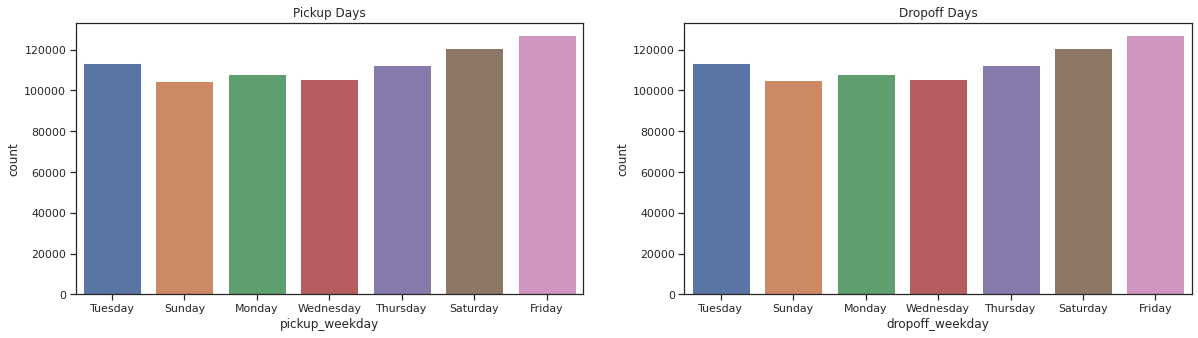

In [ ]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_weekday",data=df,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_weekday",data=df,ax=ax2)

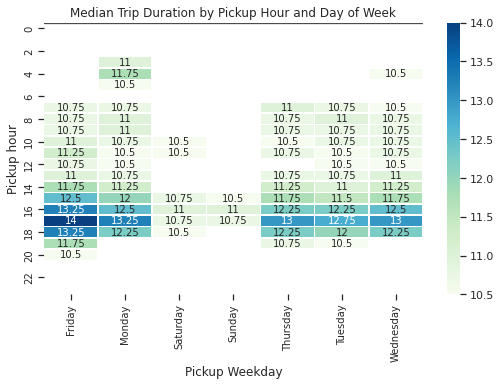

In [ ]:
# Trips by Hour and Day of Week
trip_duration_median = df['trip_time'].median()
plt.figure(figsize=(8.5,5))
pickup_hourday = df.groupby(['pickup_hour','pickup_weekday'])['trip_time'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

hourday_graph.xaxis.label.set_visible(True)
hourday_graph.yaxis.label.set_visible(True)

plt.ylabel('Pickup hour')
plt.xlabel('Pickup Weekday')
plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

###Trips per months

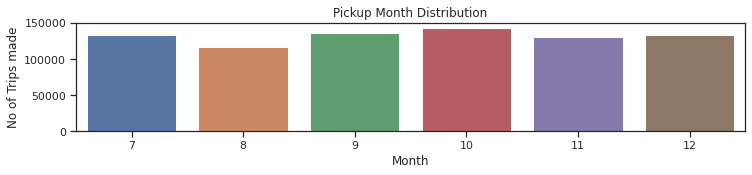

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,2))

bar_df = df.groupby('pickup_month').aggregate({'id':'count'}).reset_index()
sns.barplot(x='pickup_month', y='id', data=bar_df)

plt.title('Pickup Month Distribution')
plt.xlabel('Month')
plt.ylabel('No of Trips made')
plt.show()

In [ ]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'call_type', 'origin_call', 'origin_stand',
       'taxi_id', 'timestamp', 'day_type', 'missing_data', 'polyline',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_distance', 'trip_time', 'avg_speed',
       'pickup_datetime', 'pickup_date', 'pickup_time', 'pickup_weekday',
       'pickup_day_no', 'pickup_month', 'pickup_hour', 'pickup_minute',
       'trip_time_delta', 'dropoff_datetime', 'dropoff_time', 'dropoff_date',
       'dropoff_weekday', 'dropoff_day_no', 'dropoff_month', 'dropoff_hour',
       'dropoff_minute', 'id'],
      dtype='object')

### Pickup hours per trip duration and distance

In [ ]:
gf = sns.lineplot(x='pickup_hour', y='trip_time', data=df)
gf.set_xlabel('Pickup Hour')
gf.set_ylabel('Average Trip Duration (min)')

### Pickup day per trip duration

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

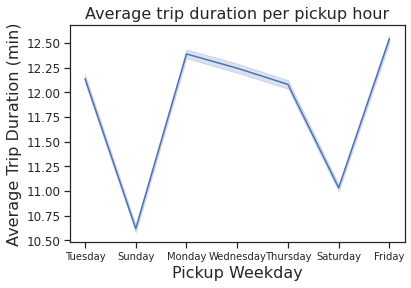

In [ ]:
gf = sns.lineplot(x='pickup_weekday', y='trip_time', data=df)
gf.set_xlabel('Pickup Weekday', fontsize=16)
gf.set_ylabel('Average Trip Duration (min)', fontsize=16)
gf.set_title('Average trip duration per pickup hour', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)


Text(0, 0.5, 'Pickup longitude)')

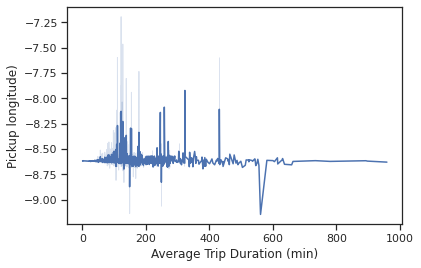

In [ ]:
gf = sns.lineplot(x='trip_time', y='pickup_longitude', data=df)
gf.set_xlabel('Average Trip Duration (min)')
gf.set_ylabel('Pickup longitude)')

In [ ]:
df_train_agg = df.groupby('trip_distance')['trip_time'].aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.trip_distance.values, df_train_agg.trip_time.values)
plt.show()

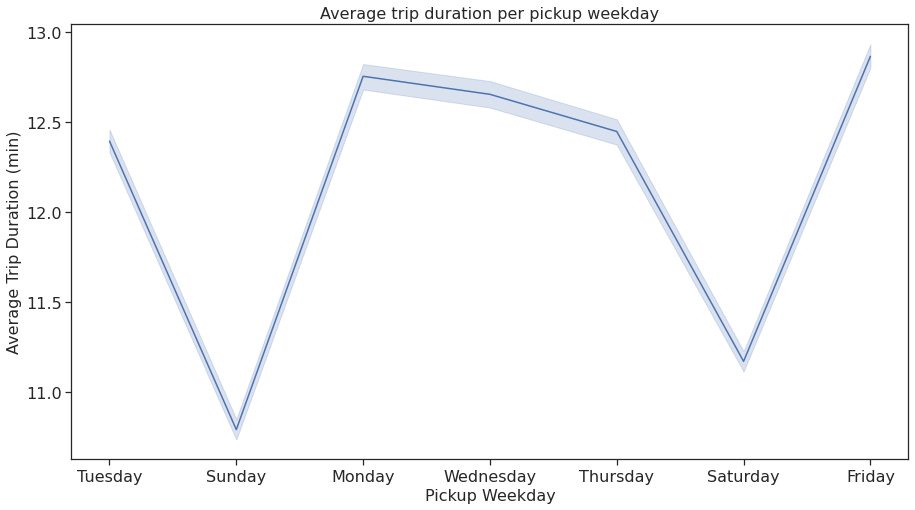

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(x='pickup_weekday', y='trip_time', data=df)
plt.xlabel('Pickup Weekday', fontsize=16)
plt.ylabel('Average Trip Duration (min)', fontsize=16)
plt.title('Average trip duration per pickup weekday', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x='pickup_weekday', y='trip_time', data=df)
plt.xlabel('Pickup Weekday', fontsize=16)
plt.ylabel('Average Trip Duration (min)', fontsize=16)
plt.title('Average trip duration per pickup weekday', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

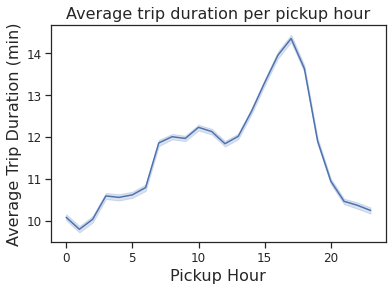

In [ ]:
#plt.figure(figsize=(15,8))
gf = sns.lineplot(x='pickup_hour', y='trip_time', data=df)
gf.set_xlabel('Pickup Hour', fontsize=16)
gf.set_ylabel('Average Trip Duration (min)', fontsize=16)
gf.set_title('Average trip duration per pickup hour', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

In [ ]:
df_train_agg = df.groupby('pickup_month')['trip_time'].aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.pickup_month.values, df_train_agg.trip_time.values)
plt.show()

In [ ]:
gf = sns.lineplot(x='trip_distance', y='trip_time', data=df).aggregate(np.median)
gf.set_xlabel('Trip Distance')
gf.set_ylabel('Average Trip Duration (min)')

### Pickup hour per trip distance

In [ ]:
gf = sns.lineplot(x='pickup_hour', y='trip_distance', data=df)
gf.set_xlabel('Pickup Hour')
gf.set_ylabel('Average Trip Distance (km)')

### Pickup day per trip distance

Text(0, 0.5, 'Average Trip Distance (km)')

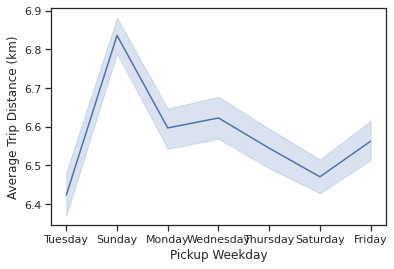

In [ ]:
gf = sns.lineplot(x='pickup_weekday', y='trip_distance', data=df)
gf.set_xlabel('Pickup Weekday')
gf.set_ylabel('Average Trip Distance (km)')

### Trip Distance per Trip Duration

In [ ]:
#Relation between trip distance and trip time
import plotly.graph_objs as go
data = [go.Histogram2dContour(x=df.trip_distance, y=df.trip_time)]
layout = go.Layout(
    xaxis=dict(range=[0, 10], title="Trip distance [km]"),
    yaxis=dict(range=[0, 20], title="Trip time [min]"),
)
fig = go.Figure(data=data, layout=layout)

fig.show()

#Pickups and Dropoffs map

In [ ]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,8))
plt.plot(longitude,latitude,'.',alpha = .40, markersize = .8)
plt.title('Trip Plots')
plt.show()

In [ ]:
#df.to_csv("porto_taxi.csv.zip", index=None, compression="zip")

In [ ]:
df.info()

In [ ]:
df.to_csv('/content/drive/MyDrive/Bachelorarbeit/preprocessed2013_porto_taxi.csv')